In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import libpysal as lps
from esda import moran
from splot import esda
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR

In [2]:
data_lsoa = gpd.read_file('data/crime_lsoa.geojson')
data_lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   lsoa11cd       4835 non-null   object  
 1   lsoa11nm       4835 non-null   object  
 2   drug_count     4835 non-null   float64 
 3   violent_count  4835 non-null   float64 
 4   pubs_count     4835 non-null   int64   
 5   popden         4835 non-null   int64   
 6   drug_rate      4835 non-null   float64 
 7   violent_rate   4835 non-null   float64 
 8   pubs_density   4835 non-null   float64 
 9   Income         4835 non-null   float64 
 10  Employment     4835 non-null   float64 
 11  Education      4835 non-null   float64 
 12  Health         4835 non-null   float64 
 13  Crime          4835 non-null   float64 
 14  Barriers       4835 non-null   float64 
 15  Environment    4835 non-null   float64 
 16  geometry       4835 non-null   geometry
dtypes: float64(12), geometry(

In [3]:
data_lsoa.set_crs(epsg=27700, allow_override=True, inplace=True)

,lsoa11cd,lsoa11nm,drug_count,violent_count,pubs_count,popden,drug_rate,violent_rate,pubs_density,Income,Employment,Education,Health,Crime,Barriers,Environment,geometry
0,E01000001,City of London 001A,12.0,12.0,5,13475,6.861063,6.861063,38.461538,0.010,0.071,0.002,0.512,0.127,33.518,32.163,"POLYGON ((532105.330 182017.386, 532162.728 18..."
1,E01000002,City of London 001B,15.0,30.0,3,7347,8.939213,17.878427,13.043478,2.131,1.173,0.009,2.280,0.039,23.197,20.749,"POLYGON ((532747.048 181793.042, 532671.921 18..."
2,E01000003,City of London 001C,0.0,19.0,2,32149,0.000000,10.000000,33.333333,12.962,17.523,4.964,14.094,2.542,58.754,45.907,"POLYGON ((532135.385 182204.275, 532158.489 18..."
3,E01000005,City of London 001E,70.0,115.0,22,11503,32.095369,52.728106,115.789474,37.706,32.041,21.974,13.706,1.269,58.227,28.053,"POLYGON ((533808.170 180773.910, 533649.287 18..."
4,E01000006,Barking and Dagenham 016A,15.0,27.0,1,14441,7.085498,12.753897,6.666667,19.180,9.390,14.208,9.505,12.555,71.868,25.337,"POLYGON ((545122.084 184321.013, 545271.951 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,2.0,9.0,1,13564,1.173021,5.278592,7.692308,11.396,3.684,6.977,9.030,11.800,59.800,9.598,"POLYGON ((544642.760 179830.773, 544766.392 17..."
4831,E01033743,Greenwich 002H,5.0,55.0,1,2327,2.145923,23.605150,1.000000,22.202,9.896,8.424,12.283,20.416,88.313,9.016,"POLYGON ((546579.271 181103.898, 546687.117 18..."
4832,E01033744,Greenwich 007G,6.0,89.0,1,12338,3.314917,49.171271,6.666667,32.225,27.215,17.340,40.764,24.693,51.637,11.255,"POLYGON ((544536.564 179453.221, 544602.707 17..."
4833,E01033745,Greenwich 002I,5.0,35.0,1,3523,2.516356,17.614494,1.785714,26.462,20.189,8.981,12.192,10.442,71.649,11.949,"POLYGON ((546415.827 180158.362, 546320.798 18..."


In [4]:
data_lsoa['popden_log'] = np.log(data_lsoa['popden'])

<AxesSubplot:>

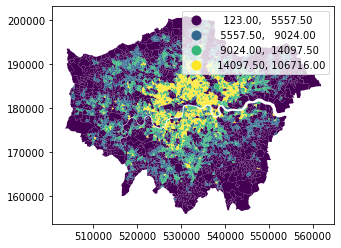

In [5]:
data_lsoa.plot(column='popden', scheme='QUANTILES', k=4, legend=True)

In [6]:
data_lsoa.corr()

,drug_count,violent_count,pubs_count,popden,drug_rate,violent_rate,pubs_density,Income,Employment,Education,Health,Crime,Barriers,Environment,popden_log
drug_count,1.000000,0.781250,0.601050,0.041644,0.951818,0.719939,0.378038,0.157659,0.136910,0.071962,0.165195,0.303903,0.167082,0.245490,0.035369
violent_count,0.781250,1.000000,0.518068,0.055125,0.710800,0.915521,0.326239,0.302053,0.283450,0.209160,0.289259,0.394354,0.268243,0.262110,0.068109
pubs_count,0.601050,0.518068,1.000000,-0.009910,0.642712,0.553517,0.570860,-0.048153,-0.040361,-0.080372,0.001169,0.030947,-0.016166,0.190095,-0.029254
popden,0.041644,0.055125,-0.009910,1.000000,0.022297,0.009318,0.502944,0.302688,0.232470,0.051776,0.298418,0.113152,0.096458,0.393580,0.861686
drug_rate,0.951818,0.710800,0.642712,0.022297,1.000000,0.756862,0.398037,0.178976,0.167602,0.081975,0.186643,0.308688,0.158026,0.232382,0.012563
violent_rate,0.719939,0.915521,0.553517,0.009318,0.756862,1.000000,0.345010,0.349114,0.354441,0.240067,0.342592,0.407867,0.259971,0.232237,0.025536
pubs_density,0.378038,0.326239,0.570860,0.502944,0.398037,0.345010,1.000000,0.110958,0.095181,-0.078970,0.180249,0.142606,-0.021374,0.399591,0.450024
Income,0.157659,0.302053,-0.048153,0.302688,0.178976,0.349114,0.110958,1.000000,0.949679,0.703121,0.773544,0.468358,0.537640,0.073976,0.321617
Employment,0.136910,0.283450,-0.040361,0.232470,0.167602,0.354441,0.095181,0.949679,1.000000,0.688707,0.774564,0.441628,0.471107,0.033244,0.250106
Education,0.071962,0.209160,-0.080372,0.051776,0.081975,0.240067,-0.078970,0.703121,0.688707,1.000000,0.518538,0.301055,0.456735,-0.121636,0.053636


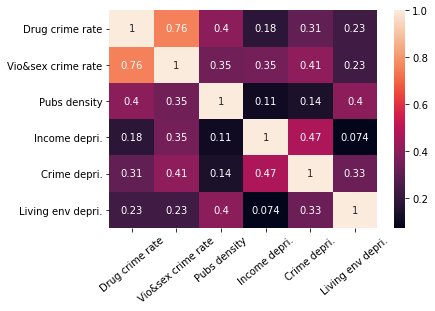

In [48]:
corr = data_lsoa[['drug_rate', 'violent_rate', 'pubs_density', 'Income', 'Crime', 'Environment']].corr()
corr.columns=['Drug crime rate', 'Vio&sex crime rate', 'Pubs density', 'Income depri.', 'Crime depri.', 'Living env depri.']
corr.index = corr.columns

plt.figure()
sns.heatmap(corr, annot=True)
plt.xticks(rotation=40)
plt.savefig('fig/corr.png', dpi=200, bbox_inches='tight')
plt.show()

In [47]:
data_lsoa[['drug_rate', 'violent_rate', 'pubs_density', 'Income', 'Crime', 'Environment']].describe()

,drug_rate,violent_rate,pubs_density,Income,Crime,Environment
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,4.431978,25.872292,8.003489,23.039379,25.204532,29.900909
std,7.143368,19.673942,9.685833,15.614250,16.102409,15.229658
min,0.000000,0.000000,0.100705,0.005000,0.037000,2.930000
25%,1.382648,14.693639,3.333333,10.637000,13.110000,18.786500
50%,2.972652,22.377622,5.555556,20.761000,22.071000,27.473000
75%,5.323278,32.450150,9.090909,33.229000,33.749500,37.973000
max,244.931507,465.205479,200.000000,92.039000,97.810000,100.000000


In [35]:
X = data_lsoa[['violent_rate', 'pubs_density', 'Crime', 'Income', 'Environment']]
df_vif = X.assign(const=1)
vif_res = pd.Series([variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])], index=df_vif.columns)
vif_res

violent_rate    1.384306
pubs_density    1.308013
Crime           1.547745
Income          1.353658
Environment     1.328518
const           6.955930
dtype: float64

# OLS

In [36]:
y = data_lsoa['drug_rate']
# X = (X - X.mean(axis=0)) / X.std(axis=0)
# y = (y - y.mean(axis=0)) / y.std(axis=0)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              drug_rate   R-squared (uncentered):                   0.700
Model:                            OLS   Adj. R-squared (uncentered):              0.700
Method:                 Least Squares   F-statistic:                              2259.
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                        0.00
Time:                        23:59:15   Log-Likelihood:                         -14240.
No. Observations:                4835   AIC:                                  2.849e+04
Df Residuals:                    4830   BIC:                                  2.852e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
violent_rate     0.2544      0.004     65.016      0.000       0.247       0.262
pubs_density     0.1225      0.008     15.699      0.000       0.107       0.138
Crime            0.0122      0.005      2.399      0.016       0.002       0.022
Income          -0.0758      0.005    -16.347      0.000      -0.085      -0.067
Environment     -0.0442      0.004    -10.782      0.000      -0.052      -0.036
==============================================================================
Omnibus:                     5217.372   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1741796.545
Skew:                           4.865   Prob(JB):                         0.00
Kurtosis:                      95.473   Cond. No.                         7.14
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              drug_rate   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     1470.
Date:                Sat, 23 Apr 2022   Prob (F-statistic):               0.00
Time:                        23:59:22   Log-Likelihood:                -14130.
No. Observations:                4835   AIC:                         2.827e+04
Df Residuals:                    4829   BIC:                         2.831e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.5523      0.171    -14.951      0.000      -2.887      -2.218
violent_rate     0.2633      0.004     68.005      0.000       0.256       0.271
pubs_density     0.1149      0.008     15.035      0.000       0.100       0.130
Crime            0.0199      0.005      3.972      0.000       0.010       0.030
Income          -0.0513      0.005    -10.629      0.000      -0.061      -0.042
Environment     -0.0022      0.005     -0.451      0.652      -0.012       0.007
==============================================================================
Omnibus:                     4869.962   Durbin-Watson:                   1.913
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1502213.631
Skew:                           4.301   Prob(JB):                         0.00
Kurtosis:                      88.923   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:              OLS              Adj. R-squared:     0.603     
Dependent Variable: drug_rate        AIC:                28272.8653
Date:               2022-04-24 10:35 BIC:                28311.7671
No. Observations:   4835             Log-Likelihood:     -14130.   
Df Model:           5                F-statistic:        1470.     
Df Residuals:       4829             Prob (F-statistic): 0.00      
R-squared:          0.603            Scale:              20.255    
--------------------------------------------------------------------
                Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
--------------------------------------------------------------------
const          -2.5523    0.1707  -14.9514  0.0000  -2.8870  -2.2176
violent_rate    0.2633    0.0039   68.0052  0.0000   0.2557   0.2708
pubs_density    0.1149    0.0076   15.0346  0.0000   0.0999   0.1299
Crime           0.0199    0.0050    3.9717  0.0001   0.0101   0.0297
Income         -0.0513    0.0048  -10.6291  0.0000  -0.0607  -0.0418
Environment    -0.0022    0.0049   -0.4508  0.6521  -0.0118   0.0074
-------------------------------------------------------------------
Omnibus:             4869.962     Durbin-Watson:        1.913      
Prob(Omnibus):       0.000        Jarque-Bera (JB):     1502213.631
Skew:                4.301        Prob(JB):             0.000      
Kurtosis:            88.923       Condition No.:        153        
===================================================================

"""

In [30]:
X.describe()

,const,violent_rate,pubs_density,Crime,Income,Environment
count,4835.0,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,1.0,25.872292,8.003489,25.204532,23.039379,29.900909
std,0.0,19.673942,9.685833,16.102409,15.614250,15.229658
min,1.0,0.000000,0.100705,0.037000,0.005000,2.930000
25%,1.0,14.693639,3.333333,13.110000,10.637000,18.786500
50%,1.0,22.377622,5.555556,22.071000,20.761000,27.473000
75%,1.0,32.450150,9.090909,33.749500,33.229000,37.973000
max,1.0,465.205479,200.000000,97.810000,92.039000,100.000000


# Moran

In [11]:
weights = lps.weights.Queen.from_dataframe(data_lsoa)
mor = moran.Moran(y, weights)
print(f'Global Moran\'s I: {mor.I}')
print(f'P value: {mor.p_sim}')
print(f'Expected Moran\'s I under null hypothesis: {mor.EI}')
print(f'Z score: {mor.z_sim}')

Global Moran's I: 0.29868850531869207
P value: 0.001
Expected Moran's I under null hypothesis: -0.0002068680182043856
Z score: 36.16249482913051


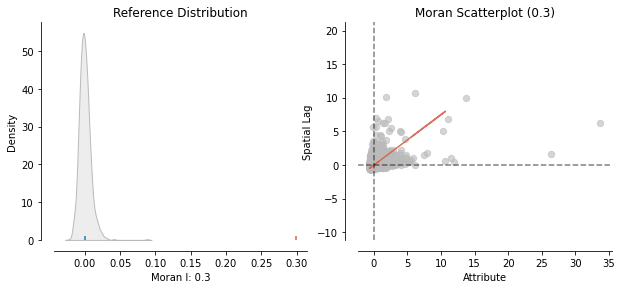

In [12]:
fig, ax = esda.plot_moran(mor, zstandard=True, figsize=(10,4))
# plt.savefig('fig/globalmoran.png', dpi=200)
plt.show()

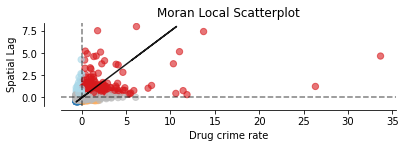

In [59]:
mor_local = moran.Moran_Local(y, weights)
fig, ax = plt.subplots()
esda.moran_scatterplot(mor_local, p=0.05, ax=ax)
ax.set_xlabel('Drug crime rate')
plt.savefig('fig/localmoran.png', dpi=200)
plt.show()

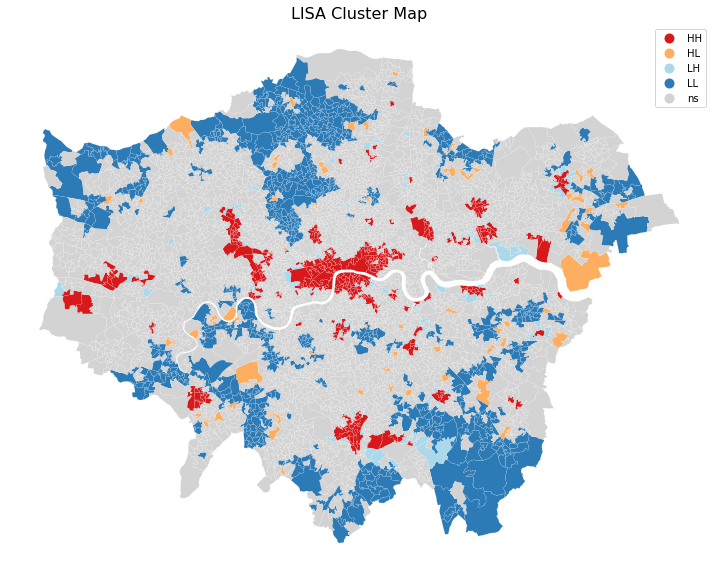

In [60]:
fig, ax=plt.subplots(1, figsize=(14,10))
fig = esda.lisa_cluster(mor_local, data_lsoa, ax=ax)
plt.title("LISA Cluster Map", fontsize=16)
plt.savefig('fig/lisa.png', dpi=200)
plt.show()

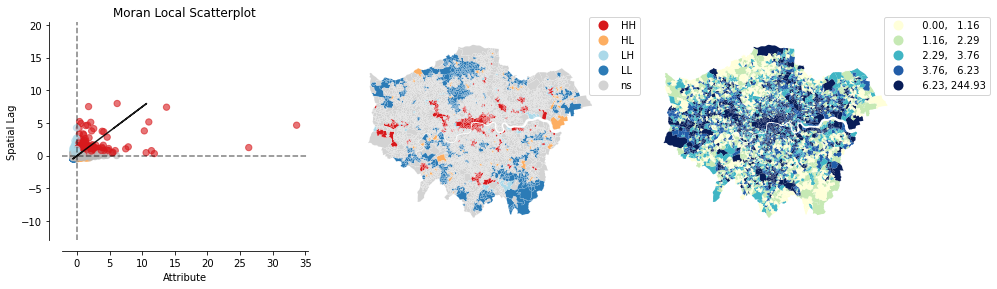

In [58]:
esda.plot_local_autocorrelation(mor_local, data_lsoa, 'drug_rate')
plt.show()

# GWR

In [15]:
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = data_lsoa['geometry'].centroid
u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [16]:
X

,const,violent_rate,pubs_density,Crime,Income,Environment
0,1.0,6.861063,38.461538,0.127,0.010,32.163
1,1.0,17.878427,13.043478,0.039,2.131,20.749
2,1.0,10.000000,33.333333,2.542,12.962,45.907
3,1.0,52.728106,115.789474,1.269,37.706,28.053
4,1.0,12.753897,6.666667,12.555,19.180,25.337
...,...,...,...,...,...,...
4830,1.0,5.278592,7.692308,11.800,11.396,9.598
4831,1.0,23.605150,1.000000,20.416,22.202,9.016
4832,1.0,49.171271,6.666667,24.693,32.225,11.255
4833,1.0,17.614494,1.785714,10.442,26.462,11.949


In [17]:
g_y = data_lsoa['drug_rate'].values.reshape(-1,1)
g_X = X.drop(columns=['const']).values
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

gwr_selector = Sel_BW(coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
results = GWR(coords, g_y, g_X, gwr_bw).fit()

89.0


In [18]:
results.summary()

Model type                                                         Gaussian
Number of observations:                                                4835
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           1917.270
Log-likelihood:                                                   -4624.431
AIC:                                                               9260.862
AICc:                                                              9262.886
BIC:                                                             -39050.210
R2:                                                                   0.603
Adj. R2:                                                              0.603

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [19]:
filtered_estimates = pd.DataFrame(results.filter_tvals(alpha=0.05))
r2 = pd.DataFrame(results.localR2)
gwr_param = pd.DataFrame(data_lsoa['lsoa11cd'])
gwr_param = gwr_param.assign(intercept=filtered_estimates[0],
                            violent_estimate=filtered_estimates[1],
                            pubs_estimate=filtered_estimates[2],
                            crime_estimate=filtered_estimates[3],
                            income_estimate=filtered_estimates[4],
                            environment_estimate=filtered_estimates[5],
                            localR2=r2)
gwr_param.head()

,lsoa11cd,intercept,violent_estimate,pubs_estimate,crime_estimate,income_estimate,environment_estimate,localR2
0,E01000001,5.034020,53.270070,-3.344777,0.000000,-2.749671,-3.725751,0.955847
1,E01000002,4.895945,53.736492,-2.258139,0.000000,0.000000,-3.878311,0.965418
2,E01000003,4.681013,52.376030,-3.876311,0.000000,0.000000,-2.542223,0.953387
3,E01000005,7.654426,54.429563,0.000000,-3.107158,0.000000,0.000000,0.963550
4,E01000006,2.817943,11.438215,0.000000,2.033936,0.000000,0.000000,0.719289


In [20]:
res_gwr = data_lsoa.merge(gwr_param, on='lsoa11cd')
res_gwr.head()

,lsoa11cd,lsoa11nm,drug_count,violent_count,pubs_count,popden,drug_rate,violent_rate,pubs_density,Income,...,Environment,geometry,popden_log,intercept,violent_estimate,pubs_estimate,crime_estimate,income_estimate,environment_estimate,localR2
0,E01000001,City of London 001A,12.0,12.0,5,13475,6.861063,6.861063,38.461538,0.010,...,32.163,"POLYGON ((532105.330 182017.386, 532162.728 18...",9.508591,5.034020,53.270070,-3.344777,0.000000,-2.749671,-3.725751,0.955847
1,E01000002,City of London 001B,15.0,30.0,3,7347,8.939213,17.878427,13.043478,2.131,...,20.749,"POLYGON ((532747.048 181793.042, 532671.921 18...",8.902047,4.895945,53.736492,-2.258139,0.000000,0.000000,-3.878311,0.965418
2,E01000003,City of London 001C,0.0,19.0,2,32149,0.000000,10.000000,33.333333,12.962,...,45.907,"POLYGON ((532135.385 182204.275, 532158.489 18...",10.378137,4.681013,52.376030,-3.876311,0.000000,0.000000,-2.542223,0.953387
3,E01000005,City of London 001E,70.0,115.0,22,11503,32.095369,52.728106,115.789474,37.706,...,28.053,"POLYGON ((533808.170 180773.910, 533649.287 18...",9.350363,7.654426,54.429563,0.000000,-3.107158,0.000000,0.000000,0.963550
4,E01000006,Barking and Dagenham 016A,15.0,27.0,1,14441,7.085498,12.753897,6.666667,19.180,...,25.337,"POLYGON ((545122.084 184321.013, 545271.951 18...",9.577827,2.817943,11.438215,0.000000,2.033936,0.000000,0.000000,0.719289


In [68]:
res_gwr[['intercept','violent_estimate', 'pubs_estimate', 'income_estimate', 'crime_estimate', 'environment_estimate', 'localR2']].describe()

,intercept,violent_estimate,pubs_estimate,income_estimate,crime_estimate,environment_estimate,localR2
count,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000,4835.000000
mean,-0.189604,4.894098,0.149930,-0.261091,0.815823,0.124651,0.571046
std,1.584594,7.336985,1.395658,1.452718,1.758146,1.114452,0.164566
min,-6.558567,-8.003859,-6.967302,-10.109704,-4.242987,-7.449553,-0.374006
25%,0.000000,2.001060,0.000000,0.000000,0.000000,0.000000,0.472341
50%,0.000000,3.427878,0.000000,0.000000,0.000000,0.000000,0.566174
75%,0.000000,5.540608,0.000000,0.000000,0.000000,0.000000,0.669781
max,7.854469,62.405473,12.961573,4.510611,15.161157,8.319990,0.972829


/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/Users/jiang/opt/anaconda3/envs/msda2021/lib/python3.8/site-packages/geopandas/plotting.py

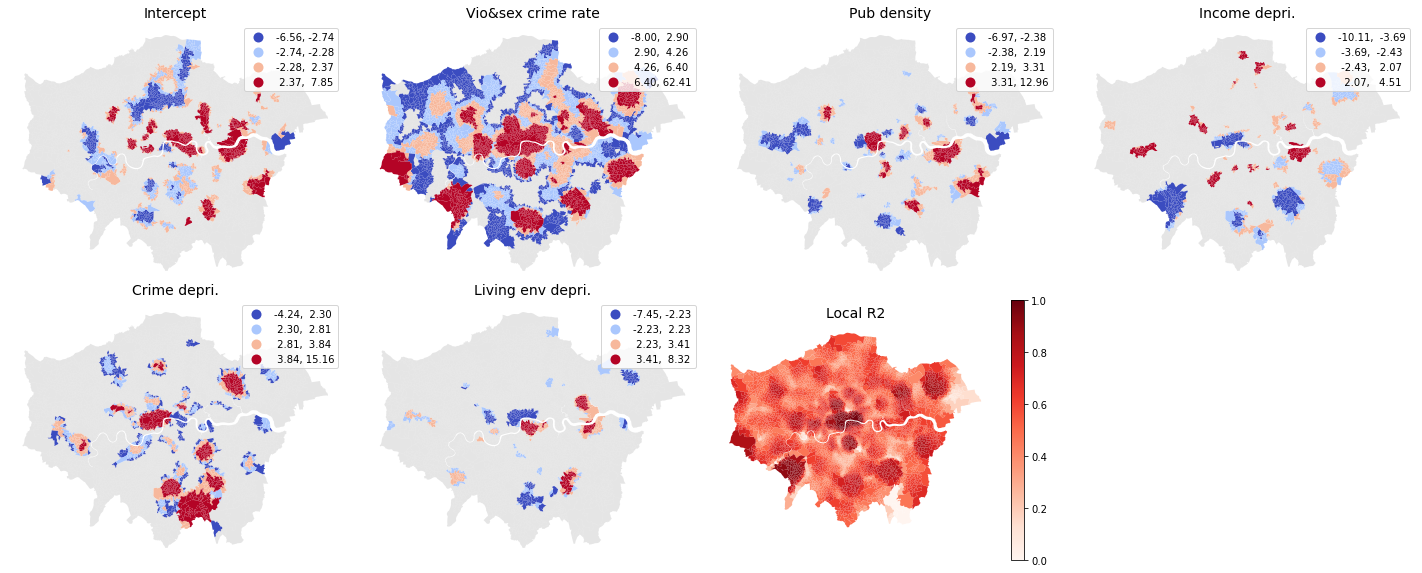

In [77]:
f,ax=plt.subplots(2,4, figsize=(20,8), subplot_kw=dict(aspect='equal'))
ax = ax.flatten()
# Define the title of our plots
attrs = ['intercept','violent_estimate', 'pubs_estimate', 'income_estimate', 'crime_estimate', 'environment_estimate']
titles = ['Intercept', 'Vio&sex crime rate', 'Pub density', 'Income depri.', 'Crime depri.', 'Living env depri.']

for i in range(len(attrs)):
    col = attrs[i]
    data_plot = res_gwr[['geometry', col]]
    data_plot.loc[data_plot[col]==0].sort_values(col).plot(column=col, color='gray', ax=ax[i], alpha=0.2)
    data_plot.loc[data_plot[col]!=0].sort_values(col).plot(column=col, scheme='QUANTILES', k=4, cmap='coolwarm', ax=ax[i], legend=True)

    ax[i].set_title(titles[i], fontsize=14)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

data_plot = res_gwr[['geometry', 'localR2']].sort_values('localR2').plot(column='localR2', ax=ax[-2], vmin=0, vmax=1, legend=True, cmap='Reds')
ax[-2].set_xticklabels([])
ax[-2].set_yticklabels([])
ax[-2].set_xticks([])
ax[-2].set_yticks([])
ax[-2].set_title('Local R2', fontsize=14)

for i in ax:
    i.set_axis_off()

f.tight_layout()
plt.savefig('fig/gwr.png')
plt.show()